# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Arguments" data-toc-modified-id="Arguments-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Arguments</a></div><div class="lev1 toc-item"><a href="#MetaCyc-subset-of-QM9" data-toc-modified-id="MetaCyc-subset-of-QM9-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>MetaCyc subset of QM9</a></div><div class="lev2 toc-item"><a href="#Delta-G^\circ_{QM9}-compounds-to-reactions" data-toc-modified-id="Delta-G^\circ_{QM9}-compounds-to-reactions-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>$\Delta G^\circ_{QM9}$ compounds to reactions</a></div><div class="lev2 toc-item"><a href="#Delta-G^\circ_{QM9}-vs-\Delta-G^\circ_{GCM}" data-toc-modified-id="Delta-G^\circ_{QM9}-vs-\Delta-G^\circ_{GCM}-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>$\Delta G^\circ_{QM9}$ vs $\Delta G^\circ_{GCM}$</a></div><div class="lev1 toc-item"><a href="#Define-model-and-optimizer" data-toc-modified-id="Define-model-and-optimizer-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define model and optimizer</a></div><div class="lev1 toc-item"><a href="#Statistics" data-toc-modified-id="Statistics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Statistics</a></div><div class="lev1 toc-item"><a href="#Create-model" data-toc-modified-id="Create-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create model</a></div><div class="lev1 toc-item"><a href="#get-the-best-checkpoint-if-available-without-training" data-toc-modified-id="get-the-best-checkpoint-if-available-without-training-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>get the best checkpoint if available without training</a></div>

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable

import time
import argparse
import os
import numpy as np
import sys
sys.path.append(os.getcwd())
# Our Modules
import utils
from utils import datasets
from models.MPNN import MPNN
from models.MPNNv2 import MPNNv2
from models.MPNNv3 import MPNNv3
from utils.LogMetric import AverageMeter, Logger


# Arguments

In [2]:
parser = argparse.ArgumentParser(description='Neural message passing')

parser.add_argument('--dataset', default='qm9', help='QM9')
parser.add_argument('--edge-rep', default='raw_distance', choices=['raw_distance','chem_graph','distance_bin'] )
parser.add_argument('--datasetPath', default='./mpnn-data/qm9/dsgdb9nsd/', help='dataset path')
parser.add_argument('--logPath', default='./log/qm9/mpnn/', help='log path')
parser.add_argument('--plotLr', default=False, help='allow plotting the data')
parser.add_argument('--plotPath', default='./plot/qm9/mpnn/', help='plot path')
parser.add_argument('--resume', default='./checkpoint/qm9/mpnn/',
                    help='path to latest checkpoint')
# Optimization Options
parser.add_argument('--batch-size', type=int, default=100, metavar='N',
                    help='Input batch size for training (default: 20)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Enables CUDA training')
parser.add_argument('--epochs', type=int, default=50, metavar='N',
                    help='Number of epochs to train (default: 50)')
parser.add_argument('--lr', type=lambda x: restricted_float(x, [1e-5, 1e-2]), default=1e-3, metavar='LR',
                    help='Initial learning rate [1e-5, 5e-4] (default: 1e-4)')
parser.add_argument('--lr-decay', type=lambda x: restricted_float(x, [.01, 1]), default=0.6, metavar='LR-DECAY',
                    help='Learning rate decay factor [.01, 1] (default: 0.6)')
parser.add_argument('--schedule', type=list, default=[0.1, 0.9], metavar='S',
                    help='Percentage of epochs to start the learning rate decay [0, 1] (default: [0.1, 0.9])')
parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                    help='SGD momentum (default: 0.9)')
# i/o
parser.add_argument('--log-interval', type=int, default=20, metavar='N',
                    help='How many batches to wait before logging training status')
# Accelerating
parser.add_argument('--prefetch', type=int, default=2, help='Pre-fetching threads.')

# Model modification
parser.add_argument('--model', type=str,help='MPNN model name [MPNN, MPNNv2, MPNNv3]',
                        default='MPNN')


args = parser.parse_args(['--model','MPNNv2', '--edge-rep','chem_graph',]) #'--no-cuda'])
print(args)


Namespace(batch_size=100, dataset='qm9', datasetPath='./mpnn-data/qm9/dsgdb9nsd/', edge_rep='chem_graph', epochs=50, logPath='./log/qm9/mpnn/', log_interval=20, lr=0.001, lr_decay=0.6, model='MPNNv2', momentum=0.9, no_cuda=False, plotLr=False, plotPath='./plot/qm9/mpnn/', prefetch=2, resume='./checkpoint/qm9/mpnn/', schedule=[0.1, 0.9])


In [3]:
def restricted_float(x, inter):
    x = float(x)
    if x < inter[0] or x > inter[1]:
        raise argparse.ArgumentTypeError("%r not in range [1e-5, 1e-4]"%(x,))
    return x


In [4]:

best_er1 = 0

    # Check if CUDA is enabled
args.cuda = not args.no_cuda and torch.cuda.is_available()

    # Load data
root = args.datasetPath
root

'./mpnn-data/qm9/dsgdb9nsd/'

# MetaCyc subset of QM9

In [5]:
print('Prepare files')
import pandas as pd
qm9_metacyc = pd.read_table('Dataset/QM9_metacyc.tab')
qm9_metacyc

Prepare files


,FrameId,Name,Kegg,InChI,Smiles,Gibbs-0,cpd,nC
0,BUTYRAMIDE,butyramide,NIL,"InChI=1S/C4H9NO/c1-2-3-4(5)6/h2-3H2,1H3,(H2,5,6)",CCCC(N)=O,51.370094,./dsgdb9nsd_000262.xyz,4
1,CPD-282,cyclohex-2-enone,C02395,"InChI=1S/C6H8O/c7-6-4-2-1-3-5-6/h2,4H,1,3,5H2",C1(CCC(C=C1)=O),76.978966,./dsgdb9nsd_002060.xyz,6
2,CPD-7031,3-methylbutanal,C07329,"InChI=1S/C5H10O/c1-5(2)3-4-6/h4-5H,3H2,1-2H3",CC(C)C[CH]=O,71.711205,./dsgdb9nsd_000255.xyz,5
3,CPD-9383,glycine methyl ester,NIL,"InChI=1S/C3H7NO2/c1-6-3(5)2-4/h2,4H2,1H3",C([NH2])C(=O)OC,-3.392161,./dsgdb9nsd_000365.xyz,3
4,CYTOSINE,cytosine,C00380,"InChI=1S/C4H5N3O/c5-3-1-2-6-4(8)7-3/h1-2H,(H3,...",C1(NC(=O)N=C(N)C=1),19.905600,./dsgdb9nsd_004243.xyz,4
5,CYTOSINE,cytosine,C00380,"InChI=1S/C4H5N3O/c5-3-1-2-6-4(8)7-3/h1-2H,(H3,...",C1(NC(=O)N=C(N)C=1),19.905600,./dsgdb9nsd_004318.xyz,4
6,CYTOSINE,cytosine,C00380,"InChI=1S/C4H5N3O/c5-3-1-2-6-4(8)7-3/h1-2H,(H3,...",C1(NC(=O)N=C(N)C=1),19.905600,./dsgdb9nsd_004371.xyz,4
7,CYTOSINE,cytosine,C00380,"InChI=1S/C4H5N3O/c5-3-1-2-6-4(8)7-3/h1-2H,(H3,...",C1(NC(=O)N=C(N)C=1),19.905600,./dsgdb9nsd_004403.xyz,4
8,URACIL,uracil,C00106,"InChI=1S/C4H4N2O2/c7-3-1-2-5-4(8)6-3/h1-2H,(H2...",C1(=CC(NC(=O)N1)=O),-28.995518,./dsgdb9nsd_004258.xyz,4
9,URACIL,uracil,C00106,"InChI=1S/C4H4N2O2/c7-3-1-2-5-4(8)6-3/h1-2H,(H2...",C1(=CC(NC(=O)N1)=O),-28.995518,./dsgdb9nsd_004294.xyz,4


In [59]:
files = [f for f in os.listdir(root) if os.path.isfile(os.path.join(root, f))]

idx = np.random.permutation(len(files))
idx = idx.tolist()
idx

[37486,
 128401,
 99057,
 83507,
 126733,
 82307,
 56086,
 126083,
 45208,
 2640,
 55338,
 126219,
 6698,
 20199,
 128810,
 16396,
 49542,
 70514,
 117100,
 11801,
 94748,
 104171,
 86524,
 126093,
 8535,
 88353,
 43527,
 21796,
 89741,
 2090,
 411,
 95706,
 49906,
 78178,
 49895,
 34543,
 84791,
 94200,
 133028,
 92922,
 2374,
 92470,
 67359,
 117930,
 65158,
 12784,
 106508,
 87397,
 114263,
 110030,
 33825,
 98993,
 112512,
 114550,
 121246,
 89915,
 30347,
 14047,
 70830,
 73316,
 18958,
 76811,
 66095,
 41355,
 103001,
 116161,
 48816,
 25181,
 29081,
 106546,
 48565,
 77289,
 8220,
 38051,
 90402,
 69783,
 102821,
 23306,
 116549,
 18212,
 95334,
 77900,
 17834,
 16106,
 68022,
 77256,
 11215,
 59692,
 90577,
 58404,
 76274,
 93519,
 118650,
 47085,
 50847,
 113612,
 84274,
 71401,
 101941,
 40712,
 94458,
 72929,
 121894,
 94062,
 36454,
 20589,
 8346,
 30264,
 43487,
 95194,
 25463,
 107467,
 99567,
 105585,
 17242,
 6583,
 23603,
 81885,
 26450,
 93386,
 101956,
 91171,
 39900

In [60]:
valid_ids = [files[i] for i in idx[0:10000]]
test_ids = [files[i] for i in idx[10000:20000]]
train_ids = [files[i] for i in idx[20000:]]

data_train = utils.Qm9(root, train_ids, edge_transform=datasets.qm9_edges, e_representation=args.edge_rep)
data_valid = utils.Qm9(root, valid_ids, edge_transform=datasets.qm9_edges, e_representation=args.edge_rep)
data_test = utils.Qm9(root, test_ids, edge_transform=datasets.qm9_edges, e_representation=args.edge_rep)

In [ ]:
print('Define model')
# Select one graph
g_tuple, l = data_train[0]
g, h_t, e = g_tuple

vals = utils.datasets.get_values(data_valid, 0, len(data_valid), ['target_mean','target_std'])
param = np.array([file_res['params'] for file_res in vals])
param

Define model


In [ ]:
print('\tStatistics')
stat_dict_valid = datasets.get_graph_stats(data_valid, ['target_mean', 'target_std'], multiprocess_p=True)

In [9]:
data_train.set_target_transform(lambda x: datasets.normalize_data(x,stat_dict_valid['target_mean'],
                                                                            stat_dict_valid['target_std']))
data_valid.set_target_transform(lambda x: datasets.normalize_data(x, stat_dict_valid['target_mean'],
                                                                            stat_dict_valid['target_std']))
data_test.set_target_transform(lambda x: datasets.normalize_data(x, stat_dict_valid['target_mean'],
                                                                           stat_dict_valid['target_std']))

In [11]:
    train_loader = torch.utils.data.DataLoader(data_train,
                                               batch_size=args.batch_size, shuffle=True,
                                               collate_fn=datasets.collate_g,
                                               num_workers=args.prefetch, pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(data_valid,
                                               batch_size=args.batch_size, collate_fn=datasets.collate_g,
                                               num_workers=args.prefetch, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(data_test,
                                              batch_size=args.batch_size, collate_fn=datasets.collate_g,
                                              num_workers=args.prefetch, pin_memory=True)


## $\Delta G^\circ_{QM9}$ compounds to reactions

In [6]:
qm9_metacyc_dict = qm9_metacyc.set_index('cpd').to_dict()['FrameId']
qm9_metacyc_dict

{'./dsgdb9nsd_000001.xyz': 'CH4',
 './dsgdb9nsd_000002.xyz': 'AMMONIA',
 './dsgdb9nsd_000003.xyz': 'WATER',
 './dsgdb9nsd_000004.xyz': 'ACETYLENE',
 './dsgdb9nsd_000005.xyz': 'HCN',
 './dsgdb9nsd_000006.xyz': 'FORMALDEHYDE',
 './dsgdb9nsd_000007.xyz': 'CPD-9312',
 './dsgdb9nsd_000008.xyz': 'METOH',
 './dsgdb9nsd_000009.xyz': 'CPD-19558',
 './dsgdb9nsd_000011.xyz': 'ACETALD',
 './dsgdb9nsd_000012.xyz': 'FORMAMIDE',
 './dsgdb9nsd_000013.xyz': 'CPD-18984',
 './dsgdb9nsd_000014.xyz': 'ETOH',
 './dsgdb9nsd_000017.xyz': 'CPD-19003',
 './dsgdb9nsd_000018.xyz': 'ACETONE',
 './dsgdb9nsd_000019.xyz': 'ACETAMIDE',
 './dsgdb9nsd_000020.xyz': 'UREA',
 './dsgdb9nsd_000021.xyz': 'CPD-19056',
 './dsgdb9nsd_000022.xyz': 'ISO-PROPANOL',
 './dsgdb9nsd_000026.xyz': 'CPD-15163',
 './dsgdb9nsd_000028.xyz': 'CPD-8887',
 './dsgdb9nsd_000031.xyz': 'CPD-8860',
 './dsgdb9nsd_000035.xyz': 'CPD-665',
 './dsgdb9nsd_000037.xyz': 'CPD-18959',
 './dsgdb9nsd_000038.xyz': 'GLYCOLALDEHYDE',
 './dsgdb9nsd_000039.xyz': 'CP

In [7]:
metacyc_files = [( qm9_metacyc_dict['./' + os.path.basename(f)], f ) 
                     for f in os.listdir(root) 
                         if os.path.isfile(os.path.join(root, f))
                            and 
                            './' + os.path.basename(f) 
                            in qm9_metacyc_dict]
dict(metacyc_files)

{'2-5-DIHYDROXYPYRIDINE': 'dsgdb9nsd_004592.xyz',
 '2-AMINOPHENOL': 'dsgdb9nsd_004979.xyz',
 '2-BUTYNE-14-DIOL': 'dsgdb9nsd_000519.xyz',
 '2-DEHYDROPANTOYL-LACTONE': 'dsgdb9nsd_064066.xyz',
 '2-DEOXYRIBOSE': 'dsgdb9nsd_100842.xyz',
 '2-HYDROXY-2-METHYLPROPANENITRILE': 'dsgdb9nsd_000223.xyz',
 '2-HYDROXYPYRIDINE': 'dsgdb9nsd_000954.xyz',
 '2-METHOXYETHANOL': 'dsgdb9nsd_000137.xyz',
 '23-PENTANEDIONE': 'dsgdb9nsd_001644.xyz',
 '3-CYANOPYRIDINE': 'dsgdb9nsd_005349.xyz',
 '3-METHYLBENZYL-ALCOHOL': 'dsgdb9nsd_032071.xyz',
 '3-OH-BENZALDEHYDE': 'dsgdb9nsd_027964.xyz',
 '3-OH-BENZYL-ALCOHOL': 'dsgdb9nsd_032171.xyz',
 '4-AMINO-BUTYRATE': 'dsgdb9nsd_001290.xyz',
 '4-HYDROXY-2-BUTYNAL': 'dsgdb9nsd_000516.xyz',
 '4-HYDROXY-BENZYL-ALCOHOL': 'dsgdb9nsd_031871.xyz',
 '4-HYDROXY-L-PROLINE': 'dsgdb9nsd_093943.xyz',
 '4-METHYLBENZYL-ALCOHOL': 'dsgdb9nsd_031794.xyz',
 '4-METHYLCATECHOL': 'dsgdb9nsd_028440.xyz',
 '4-METHYLPENTANAL': 'dsgdb9nsd_001247.xyz',
 '4-METHYLRESORCINOL': 'dsgdb9nsd_028444.xyz',
 

In [8]:
qm9_metacyc_graphs = utils.Qm9(root,
                               sorted([f[2:] for f in qm9_metacyc_dict.keys()]),
                               edge_transform=datasets.qm9_edges, 
                               e_representation=args.edge_rep )
qm9_metacyc_vals = utils.datasets.get_values(qm9_metacyc_graphs, 
                                             0, 
                                             len(qm9_metacyc_graphs), 
                                             ['target_mean','target_std'])
qm9_metacyc_param = np.array([file_res['params'] for file_res in qm9_metacyc_vals])
qm9_metacyc_dG = pd.Series(qm9_metacyc_param[:,-2], 
                           index=[qm9_metacyc_dict[f] 
                                  for f in sorted(qm9_metacyc_dict)])
qm9_metacyc_dG.to_csv('Dataset/QM9_DFT_deltaG0f.tab',index=True, sep='\t')
qm9_metacyc_dG

CH4                      -40.498597
AMMONIA                  -56.544961
WATER                    -76.422349
ACETYLENE                -77.327429
HCN                      -93.431246
FORMALDEHYDE            -114.505268
CPD-9312                 -79.787269
METOH                   -115.701876
CPD-19558               -116.633775
ACETALD                 -153.812518
FORMAMIDE               -169.885594
CPD-18984               -119.078157
ETOH                    -154.998148
CPD-19003               -153.766642
ACETONE                 -193.116476
ACETAMIDE               -209.187468
UREA                    -225.247724
CPD-19056               -158.370016
ISO-PROPANOL            -194.294663
CPD-15163               -190.650543
CPD-8887                -227.825074
CPD-8860                -172.032826
CPD-665                 -193.102798
CPD-18959               -229.041086
GLYCOLALDEHYDE          -229.019918
CPD-18985               -158.368940
PROPANOL                -194.288930
GLYCOL                  -230

In [9]:
qm9_metacyc_dG_min = qm9_metacyc_dG.reset_index().groupby('index').min().dropna()
qm9_metacyc_dG_min.columns = ['$\Delta G^\circ_f(DFT)$']
qm9_metacyc_dG_min

,$\Delta G^\circ_f(DFT)$
index,
2-5-DIHYDROXYPYRIDINE,-398.697434
2-AMINOPHENOL,-362.761949
2-BUTYNE-14-DIOL,-306.345991
2-DEHYDROPANTOYL-LACTONE,-459.053741
2-DEOXYRIBOSE,-497.331001
2-HYDROXY-2-METHYLPROPANENITRILE,-286.536500
2-HYDROXYPYRIDINE,-323.477888
2-METHOXYETHANOL,-269.494828
23-PENTANEDIONE,-345.729675


In [10]:
stoich_matrix = pd.read_table('Dataset/QM9.S',index_col=['Rxn','Metabolite'])['Stoichiometry']
rxns, metabs = stoich_matrix.index.levels
stoich_dict = stoich_matrix.to_dict()
S = pd.DataFrame(0,index=metabs, columns=rxns)
for rxn,metab in stoich_dict:   
    S.loc[metab,rxn] = stoich_dict[rxn, metab]
#S.loc['3-HYDROXY-4H-PYRID-4-ONE','CREATINASE-RXN'] = 1
S

Rxn,25-DIOXOPIPERAZINE-HYDROLASE-RXN,ACETONE-CYANHYDRIN-LYASE-RXN,CREATINASE-RXN,CREATININASE-RXN,CYANIDE-HYDRATASE-RXN,GLYCEROL-DEHYDRATASE-RXN,GUANIDINOACETASE-RXN,R141-RXN,R313-RXN,R63-RXN,RXN-12256,RXN-12261,RXN-12765,RXN-13561,RXN-14725,RXN-14726,RXN-17589,RXN-17609,RXN-9702
Metabolite,,,,,,,,,,,,,,,,,,,
2-HYDROXY-2-METHYLPROPANENITRILE,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3-CYANOPYRIDINE,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
ACETALD,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
ACETONE,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ACETYLENE,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0
BENZALDEHYDE,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0
BENZYL-ALCOHOL,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0
BUTYRAMIDE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0
CPD-10303,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1


In [17]:
deltaG = S.T.dot(qm9_metacyc_dG_min['$\Delta G^\circ_f(DFT)$'][metabs]).to_frame('$\Delta G^\circ_{rxn}(DFT)$')
deltaG

,$\Delta G^\circ_{rxn}(DFT)$
Rxn,
25-DIOXOPIPERAZINE-HYDROLASE-RXN,0.022328
ACETONE-CYANHYDRIN-LYASE-RXN,-0.011222
CREATINASE-RXN,-0.025354
CREATININASE-RXN,0.010346
CYANIDE-HYDRATASE-RXN,0.031999
GLYCEROL-DEHYDRATASE-RXN,-0.014831
GUANIDINOACETASE-RXN,-0.024487
R141-RXN,-0.062740
R313-RXN,0.023191


In [19]:
deltaG

,$\Delta G^\circ_{rxn}(DFT)$,$\Delta G^\circ_{rxn}(GCM)$
Rxn,,
25-DIOXOPIPERAZINE-HYDROLASE-RXN,0.022328,10.196393
ACETONE-CYANHYDRIN-LYASE-RXN,-0.011222,94.642093
CREATINASE-RXN,-0.025354,-37.710394
CREATININASE-RXN,0.010346,6.891045
CYANIDE-HYDRATASE-RXN,0.031999,61.015272
GLYCEROL-DEHYDRATASE-RXN,-0.014831,-26.974242
GUANIDINOACETASE-RXN,-0.024487,-18.589547
R141-RXN,-0.062740,-425.901954
R313-RXN,0.023191,-20.823741


# Statistics

In [53]:
print('\tStatistics')
stat_dict = datasets.get_graph_stats(qm9_metacyc_graphs, ['target_mean', 'target_std'], multiprocess_p=False)
stat_dict

	Statistics


{'target_mean': array([  2.84882356e+00,   6.24558396e+01,  -2.43285213e-01,
          2.97343358e-03,   2.46261153e-01,   9.48892067e+02,
          1.22787501e-01,  -3.53157283e+02,  -3.53149925e+02,
         -3.53148981e+02,  -3.53188890e+02,   2.65806416e+01]),
 'target_std': array([  1.90921915e+00,   1.64102332e+01,   2.79053602e-02,
          4.36344142e-02,   5.68197076e-02,   4.57491802e+02,
          3.75776799e-02,   9.08118945e+01,   9.08108440e+01,
          9.08108440e+01,   9.08140135e+01,   6.54560385e+00])}

# Define model and optimizer


In [20]:
print('Define model')
# Select one graph
g_tuple, l = qm9_metacyc_graphs[0]
g, h_t, e = g_tuple

vals = utils.datasets.get_values(qm9_metacyc_graphs, 0, len(qm9_metacyc_graphs), ['target_mean','target_std'])
param = np.array([file_res['params'] for file_res in vals])
param

Define model


array([[  0.00000000e+00,   1.32100000e+01,  -3.87700000e-01, ...,
         -4.04751170e+01,  -4.04985970e+01,   6.46900000e+00],
       [  1.62560000e+00,   9.46000000e+00,  -2.57000000e-01, ...,
         -5.65220820e+01,  -5.65449610e+01,   6.31600000e+00],
       [  1.85110000e+00,   6.31000000e+00,  -2.92800000e-01, ...,
         -7.64009220e+01,  -7.64223490e+01,   6.00200000e+00],
       ..., 
       [  5.02600000e+00,   6.52800000e+01,  -2.25000000e-01, ...,
         -4.94092047e+02,  -4.94132947e+02,   2.86280000e+01],
       [  3.62530000e+00,   6.53300000e+01,  -2.32800000e-01, ...,
         -4.94089629e+02,  -4.94129604e+02,   2.73640000e+01],
       [  3.79950000e+00,   5.99400000e+01,  -2.47300000e-01, ...,
         -5.13988164e+02,  -5.14027850e+02,   2.63000000e+01]])

In [27]:
len(qm9_metacyc_graphs)

399

In [28]:
predict_loader = torch.utils.data.DataLoader(   qm9_metacyc_graphs,
                                                batch_size=len(qm9_metacyc_graphs),
                                                shuffle=False,
                                                collate_fn=datasets.collate_g,
                                                num_workers=args.prefetch,
                                                pin_memory=True)
#for i, batch_sample in enumerate(predict_loader):
#    print(i, batch_sample)

# Create model

In [22]:
    in_n = [len(h_t[0]), len(list(e.values())[0])]
    hidden_state_size = 73
    message_size = 73
    n_layers = 3
    l_target = len(l)
    type ='regression'
    if args.model == 'MPNNv2':
        model = MPNNv2(in_n, [5, 15, 15], [10, 20, 20], l_target, type=type)
    elif args.model == 'MPNNv3':
        model = MPNNv3([1, 2, 3, 4], in_n, [5, 15, 15], 30, l_target, type=type)
    else:
        model = MPNN(in_n, hidden_state_size, message_size, n_layers, l_target, type=type)
    del in_n, hidden_state_size, message_size, n_layers, l_target, type

    print('Optimizer')
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    criterion = nn.MSELoss()

    evaluation = lambda output, target: torch.mean(torch.abs(output - target) / torch.abs(target))

    print('Logger')
    logger = Logger(args.logPath)

    lr_step = (args.lr-args.lr*args.lr_decay)/(args.epochs*args.schedule[1] - args.epochs*args.schedule[0])


Optimizer
Logger


# get the best checkpoint if available without training

In [23]:
if args.resume:
        checkpoint_dir = args.resume
        best_model_file = os.path.join(checkpoint_dir, 'model_best.pth')
        if not os.path.isdir(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        if os.path.isfile(best_model_file):
            print("=> loading best model '{}'".format(best_model_file))
            checkpoint = torch.load(best_model_file)
            args.start_epoch = checkpoint['epoch']
            best_acc1 = checkpoint['best_er1']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded best model '{}' (epoch {})".format(best_model_file, checkpoint['epoch']))
        else:
            print("=> no best model found at '{}'".format(best_model_file))


=> loading best model './checkpoint/qm9/mpnn/model_best.pth'
=> loaded best model './checkpoint/qm9/mpnn/model_best.pth' (epoch 50)


In [24]:
    print('Check cuda')
    if args.cuda:
        print('\t* Cuda')
        model = model.cuda()
        criterion = criterion.cuda()


Check cuda
	* Cuda


In [25]:
def predict(val_loader, model, logger=None):
    batch_time = AverageMeter()
    output = []
    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, batch_sample in enumerate(val_loader):
        if len(batch_sample) >= 3:
            g,h,e = batch_sample[0], batch_sample[1], batch_sample[2]
            if i == 0:
                print("Graph: {}".format(g))
                print("Hidden units: {}".format(h))
                print("Edges: {}".format(e))
        # Prepare input data
        if args.cuda:
            g, h, e = g.cuda(), h.cuda(), e.cuda()
        g, h, e = Variable(g), Variable(h), Variable(e)

        # Compute output
        output.append( model(g, h, e) )



        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

    return output


In [29]:
output = predict(predict_loader, model )
output

Graph: 
( 0 ,.,.) = 
   0   1   1  ...    0   0   0
   1   0   0  ...    0   0   0
   1   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

( 1 ,.,.) = 
   0   1   1  ...    0   0   0
   1   0   0  ...    0   0   0
   1   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

( 2 ,.,.) = 
   0   1   1  ...    0   0   0
   1   0   0  ...    0   0   0
   1   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
... 

(396,.,.) = 
   0   1   0  ...    0   0   0
   1   0   1  ...    0   0   0
   0   1   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(397,.,.) = 
   0   1   0  ...    0   0   0
   1   0   1  ...  

[Variable containing:
 -2.0052e+00 -7.8474e+00 -6.9506e+00  ...   9.4054e+00  9.4060e+00 -6.3023e+00
 -1.2630e+00 -8.1672e+00 -1.3575e+00  ...   9.1435e+00  9.1444e+00 -6.2343e+00
 -1.0947e+00 -8.6820e+00 -2.5845e+00  ...   8.7548e+00  8.7542e+00 -6.6189e+00
                 ...                   ⋱                   ...                
  1.4232e+00 -1.1728e+00  8.0772e-01  ...  -2.0489e+00 -2.0486e+00 -8.4392e-01
  3.6278e-01 -1.1223e+00  4.4064e-01  ...  -2.0715e+00 -2.0713e+00 -9.9665e-01
  8.8447e-01 -1.6625e+00 -2.4789e-01  ...  -2.5291e+00 -2.5290e+00 -1.2602e+00
 [torch.cuda.FloatTensor of size 399x12 (GPU 0)]]

In [30]:
(output[0][:,-2].data).cpu().numpy()

array([  9.40603828e+00,   9.14439201e+00,   8.75420284e+00,
         8.77559948e+00,   8.26557159e+00,   7.65450144e+00,
         8.52870655e+00,   7.75918293e+00,   7.62968969e+00,
         6.71076918e+00,   6.39958143e+00,   7.52978992e+00,
         6.50255108e+00,   6.64688969e+00,   5.67207861e+00,
         5.20376444e+00,   4.84705353e+00,   6.43422461e+00,
         5.38974667e+00,   5.68939304e+00,   4.73008251e+00,
         6.16564560e+00,   5.56163263e+00,   4.73907423e+00,
         4.72101593e+00,   6.14158440e+00,   5.54635429e+00,
         4.66327333e+00,   5.67799807e+00,   5.48907614e+00,
         4.10996342e+00,   5.23992443e+00,   4.80394983e+00,
         4.61932707e+00,   4.43146324e+00,   3.87124014e+00,
         5.16582918e+00,   4.62050438e+00,   3.77625632e+00,
         4.25221252e+00,   3.75847864e+00,   4.60642338e+00,
         4.26693201e+00,   4.14735508e+00,   3.80062580e+00,
         3.77604938e+00,   3.44183612e+00,   3.46028829e+00,
         4.62138796e+00,

In [45]:
normalized_dG_MPNN = pd.DataFrame({r'$\frac{\Delta G^\circ_{MPNN}-\mu}{\sigma}$':(output[0][:,-2].data).cpu().numpy()}, 
                      index=[qm9_metacyc_dict[f] 
                            for f in sorted(qm9_metacyc_dict)]).reset_index().groupby('index').min()
normalized_dG_MPNN

,$\frac{\Delta G^\circ_{MPNN}-\mu}{\sigma}$
index,
2-5-DIHYDROXYPYRIDINE,0.466480
2-AMINOPHENOL,1.225638
2-BUTYNE-14-DIOL,2.733291
2-DEHYDROPANTOYL-LACTONE,-1.195570
2-DEOXYRIBOSE,-2.113712
2-HYDROXY-2-METHYLPROPANENITRILE,3.249184
2-HYDROXYPYRIDINE,2.251307
2-METHOXYETHANOL,3.734717
23-PENTANEDIONE,1.749314


In [46]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr = lr.fit(normalized_dG_MPNN, qm9_metacyc_dG_min['$\Delta G^\circ_f(DFT)$'] )
linear_params= lr.get_params()

In [70]:
mu, sigma =  lr.intercept_, lr.coef_
qm9_metacyc_dG_min['$\Delta G^\circ_f$(MPNNv2,chemgraph)'] = normalized_dG_MPNN*sigma + mu
qm9_metacyc_dG_min.to_csv('Dataset/deltaG_DFT_vs_MPNNv2_chemgraph_metabolites.tab',sep='\t')
qm9_metacyc_dG_min

,$\Delta G^\circ_f(DFT)$,"$\Delta G^\circ_f$(MPNNv2,chemgraph)"
index,,
2-5-DIHYDROXYPYRIDINE,-398.697434,-394.090881
2-AMINOPHENOL,-362.761949,-364.618500
2-BUTYNE-14-DIOL,-306.345991,-306.087677
2-DEHYDROPANTOYL-LACTONE,-459.053741,-458.615784
2-DEOXYRIBOSE,-497.331001,-494.260284
2-HYDROXY-2-METHYLPROPANENITRILE,-286.536500,-286.059418
2-HYDROXYPYRIDINE,-323.477888,-324.799469
2-METHOXYETHANOL,-269.494828,-267.209839
23-PENTANEDIONE,-345.729675,-344.288086


In [71]:
deltaG['$\Delta G^\circ_{rxn}$(MPNNv2,chemgraph)'] = S.T.dot(qm9_metacyc_dG_min['$\Delta G^\circ_f$(MPNNv2,chemgraph)'][metabs]).to_frame('$\Delta G^\circ_{rxn}(DFT)$')
deltaG.to_csv('Dataset/deltaG_DFT_vs_GCM_vs_MPNNv2_chemgraph_rxns.tab',sep='\t')
deltaG

,$\Delta G^\circ_{rxn}(DFT)$,$\Delta G^\circ_{rxn}(GCM)$,"$\Delta G^\circ_{rxn}$(MPNNv2,chemgraph)"
Rxn,,,
25-DIOXOPIPERAZINE-HYDROLASE-RXN,0.022328,10.196393,-1.866394
ACETONE-CYANHYDRIN-LYASE-RXN,-0.011222,94.642093,2.751907
CREATINASE-RXN,-0.025354,-37.710394,0.047836
CREATININASE-RXN,0.010346,6.891045,-1.043518
CYANIDE-HYDRATASE-RXN,0.031999,61.015272,0.101379
GLYCEROL-DEHYDRATASE-RXN,-0.014831,-26.974242,-3.139801
GUANIDINOACETASE-RXN,-0.024487,-18.589547,0.368637
R141-RXN,-0.062740,-425.901954,-7.820831
R313-RXN,0.023191,-20.823741,11.418365


## $\Delta G^\circ_{rxn}(DFT)$ vs $\Delta G^\circ_{rxn}(GCM)$

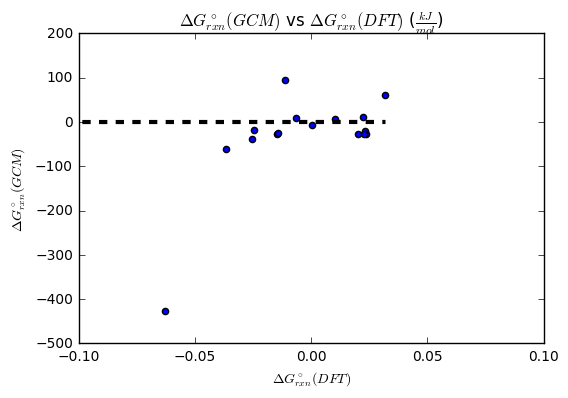

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
friendly_rxns = pd.read_table('Dataset/friendly-metacyc-rxns.tab',index_col='FrameId')
deltaG['$\Delta G^\circ_{rxn}(GCM)$'] = friendly_rxns.loc[rxns,'dG']*4.184
deltaG.plot(y='$\Delta G^\circ_{rxn}(GCM)$',
            x='$\Delta G^\circ_{rxn}(DFT)$',
            kind='scatter',
            title=r'$\Delta G^\circ_{rxn}(GCM)$ vs $\Delta G^\circ_{rxn}(DFT)$ ($\frac{kJ}{mol}$)',
            xlim=[-0.1,0.1])

identity_line = np.linspace(max(deltaG['$\Delta G^\circ_{rxn}(GCM)$'].min(), 
                                deltaG['$\Delta G^\circ_{rxn}(DFT)$'].min()),
                            min(deltaG['$\Delta G^\circ_{rxn}(GCM)$'].max(), 
                                deltaG['$\Delta G^\circ_{rxn}(DFT)$'].max()))
plt.plot(identity_line, identity_line, color="black", linestyle="dashed", linewidth=3.0)

plt.savefig('Dataset/GCM_vs_QM9.png')

## $\Delta G^\circ_{rxn}(DFT)$ vs $\Delta G^\circ_{rxn}$(MPNNv2,chemgraph)

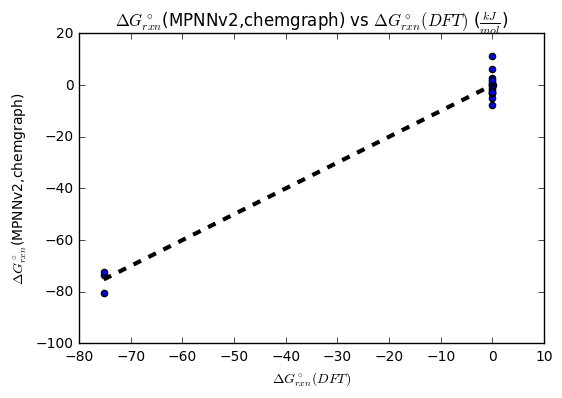

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
friendly_rxns = pd.read_table('Dataset/friendly-metacyc-rxns.tab',index_col='FrameId')

deltaG.plot(y='$\Delta G^\circ_{rxn}$(MPNNv2,chemgraph)',
            x='$\Delta G^\circ_{rxn}(DFT)$',
            kind='scatter',
            title=r'$\Delta G^\circ_{rxn}$(MPNNv2,chemgraph) vs $\Delta G^\circ_{rxn}(DFT)$ ($\frac{kJ}{mol}$)',
        )

identity_line = np.linspace(max(deltaG['$\Delta G^\circ_{rxn}$(MPNNv2,chemgraph)'].min(), 
                                deltaG['$\Delta G^\circ_{rxn}(DFT)$'].min()),
                            min(deltaG['$\Delta G^\circ_{rxn}$(MPNNv2,chemgraph)'].max(), 
                                deltaG['$\Delta G^\circ_{rxn}(DFT)$'].max()))
plt.plot(identity_line, identity_line, color="black", linestyle="dashed", linewidth=3.0)

plt.savefig('Dataset/MPNNv2_chemgraph_vs_QM9.png')